# Recreating Matlab in Python

The python version of Richardson-Lucy (RL) still doesn't behave _exactly_ like the matlab version.

Functions below are taken from commit `4df82cb88a8ad0528a1b9985ef0f6500ab04e046`

The problem is the "scale" that is calculated is not equal to 1
```matlab
scale = real(ifftn(conj(H).*fftn(WEIGHT(idx{:})))) + sqrt(eps);
...
  J{2} = max(Y.*real(ifftn(conj(H).*CC))./scale,0);
```

In [1]:
%pylab inline
import os

home = "Python vs Matlab data"

if not os.path.exists(home):
    os.mkdir(home)

%cd {home}

from skimage.external import tifffile as tif
from scipy.io import loadmat, savemat

try:
    import pyfftw
    from pyfftw.interfaces.numpy_fft import fftshift, ifftshift, fftn, ifftn, rfftn, irfftn

    # Turn on the cache for optimum performance
    pyfftw.interfaces.cache.enable()
except ImportError:
    from numpy.fft import fftshift, ifftshift, fftn, ifftn, rfftn, irfftn
from dphutils import fft_pad
import scipy.signal.signaltools as sig
from scipy.signal import fftconvolve
from scipy.ndimage import convolve

Populating the interactive namespace from numpy and matplotlib
C:\Users\hoffmand\Box Sync\Python\pyDecon\notebooks\Python vs Matlab data


In [2]:
# original functions
def _prep_img_and_psf(image, psf):
    """Do basic data checking, convert data to float, normalize psf and make
    sure data are positive"""
    assert psf.ndim == image.ndim, "image and psf do not have the same number" " of dimensions"
    image = image.astype(np.float)
    psf = psf.astype(np.float)
    # need to make sure both image and PSF are totally positive.
    image = _ensure_positive(image)
    psf = _ensure_positive(psf)
    # normalize the kernel
    psf /= psf.sum()
    return image, psf


def _ensure_positive(data):
    """Make sure data is positive and has no zeros

    For numerical stability

    If we realize that mutating data is not a problem
    and that changing in place could lead to signifcant
    speed ups we can lose the data.copy() line"""
    # make a copy of the data
    data = data.copy()
    data[data <= 0] = np.finfo(data.dtype).eps
    return data

In [63]:
def _rl_core_matlab(image, otf, psf, u_t, **kwargs):
    """The core update step of the RL algorithm

    This is a fast but inaccurate version modeled on matlab's version
    One improvement is to pad everything out when the shape isn't
    good for fft."""
    reblur = irfftn(otf * rfftn(u_t, u_t.shape, **kwargs), u_t.shape, **kwargs)
    reblur = _ensure_positive(reblur)
    im_ratio = image / reblur
    estimate = irfftn(
        np.conj(otf) * rfftn(im_ratio, im_ratio.shape, **kwargs), im_ratio.shape, **kwargs
    )
    # need to figure out a way to pass the psf shape
    for i, (s, p) in enumerate(zip(image.shape, psf.shape)):
        if s % 2 and not p % 2:
            estimate = np.roll(estimate, 1, i)
    estimate = _ensure_positive(estimate)
    return u_t * estimate


def _rl_accelerate(g_tm1, g_tm2, u_t, u_tm1, u_tm2, prediction_order):
    """Biggs-Andrews Acceleration

    .. [2] Biggs, D. S. C.; Andrews, M. Acceleration of Iterative Image
    Restoration Algorithms. Applied Optics 1997, 36 (8), 1766."""
    # TODO: everything here can be wrapped in ne.evaluate
    if g_tm2 is not None:
        alpha = (g_tm1 * g_tm2).sum() / ((g_tm2**2).sum() + np.finfo(g_tm1.dtype).eps)
        alpha = max(min(alpha, 1), 0)
    else:
        alpha = 0
    print("lambda = {:.6f}".format(alpha))
    # if alpha is positive calculate predicted step
    if alpha:
        # first order correction
        h1_t = u_t - u_tm1
        if prediction_order > 1:
            # second order correction
            h2_t = u_t - 2 * u_tm1 + u_tm2
        else:
            h2_t = 0
        u_tp1 = u_t + alpha * h1_t + alpha**2 / 2 * h2_t
        return u_tp1
    else:
        return u_t


def richardson_lucy(
    image, psf, iterations=10, prediction_order=1, core_type="matlab", init="matlab", **kwargs
):
    """
    Richardson-Lucy deconvolution.

    Parameters
    ----------
    image : ndarray
       Input degraded image (can be N dimensional).
    psf : ndarray
       The point spread function. Assumes that it has no background
    iterations : int
       Number of iterations. This parameter plays the role of
       regularisation.
    prediction_order : int (0, 1 or 2)
        Use Biggs-Andrews to accelerate the algorithm [2] default is 1
    core_type : str
        Type of core to use (see Notes)
    init : str
        How to initialize the deconvolution (see Notes)

    Returns
    -------
    im_deconv : ndarray
       The deconvolved image.

    Examples
    --------

    Notes
    -----
    This algorithm can use a variety of cores to calculate the update step [1].
    The update step basically consists of two convolutions which can be
    performed in a few different ways. The "direct" core uses direct
    convolution to calculate them and is painfully slow but is included for
    completeness. The "accurate" core uses `fftconvolve` to properly and
    quickly calculate the convolution. "fast" optimizes "accurate" by only
    performing the FFTs on the PSF _once_. The "matlab" core is based on the
    MatLab implementation of Richardson-Lucy which speeds up the convolution
    steps by avoiding padding out both data and psf to avoid the wrap around
    effect of the fftconvolve. This approach is generally accurate because the
    psf is generally very small compared to data but will not give exactly the
    same results as "accurate" or "fast" and should not be used for large or
    complicated PSFs. The "matlab" routine also avoids the tapering effect
    implicit in fftconvolve and should be used whenever any of the image
    extends to the edge of data.

    The algorithm can also be initilized in two ways: using the original image
    ("matlab") or using a constant array the same size of the image filled with
    the mean value of the image ("mean"). The advantage to starting with the
    image is that you need fewer iterations to get a good result. However,
    the disadvantage is that if there original image has low SNR the result
    will be severly degraded. A good rule of thumb is that if the SNR is low
    (SNR < 10) that `init="mean"` be used and double the number of iterations.

    References
    ----------
    .. [1] http://en.wikipedia.org/wiki/Richardson%E2%80%93Lucy_deconvolution
    .. [2] Biggs, D. S. C.; Andrews, M. Acceleration of Iterative Image
    Restoration Algorithms. Applied Optics 1997, 36 (8), 1766.

    """
    # Stolen from the dev branch of skimage because stable branch is slow
    # checked against matlab on 20160805 and agrees to within machine precision
    image, psf = _prep_img_and_psf(image, psf)
    # choose core
    if core_type == "matlab":
        core = _rl_core_matlab
    else:
        raise ValueError("{} is not an acceptable core type".format(core_type))
    # set up the proper dict for the right core
    if core is _rl_core_matlab:
        image, psf = _prep_img_and_psf(image, psf)
        if psf.shape != image.shape:
            # its been assumed that the background of the psf has already been
            # removed and that the psf has already been centered
            psf = fft_pad(psf, image.shape, mode="constant")
        otf = rfftn(ifftshift(psf))
        core_dict = dict(image=image, otf=otf, psf=psf)
    else:
        raise RuntimeError("{} is not a valid core".format(core))
    # initialize variable for iterations
    # previous estimate
    u_tm1 = u_tm2 = None
    if init == "matlab":
        core_dict["u_t"] = u_t = image
    else:
        # current estimate, for the initial estimate we use the mean of the
        # data this promotes a smooth solution and helps to reduce noise.
        core_dict["u_t"] = u_t = np.ones_like(image) * image.mean()
    # previous difference
    g_tm1 = g_tm2 = None
    for i in range(iterations):
        # if prediction is requested perform it
        if prediction_order:
            # need to save prediction as intermediate value
            y = _rl_accelerate(g_tm1, g_tm2, u_t, u_tm1, u_tm2, prediction_order)
        else:
            y = u_t
        # update estimate and ensure positive
        core_dict["u_t"] = _ensure_positive(y)
        # call the update function
        u_tp1 = core(**core_dict, **kwargs)
        # update
        # update g's
        g_tm2 = g_tm1
        # this is where the magic is, we need to compute from previous step
        # which may have been augmented by acceleration
        g_tm1 = u_tp1 - y
        # now move u's along
        # Here we don't want to update with accelerated version.
        # why not? is this a mistake?
        u_t, u_tm1, u_tm2 = u_tp1, u_t, u_tm1

    # return final estimate
    return u_t

In [64]:
def gen_data():
    print("Generating the data ...")
    x = np.linspace(-2.5, 2.5, 64, True)
    kernel = np.exp(-(x**2))
    kernel = kernel[np.newaxis] * kernel[:, np.newaxis]
    # normalize kernel
    k_norm = kernel / kernel.sum()
    # make signal
    x = np.linspace(-10, 10, 512)
    signal = 5.0 * np.logical_and(x < 3, x > -3)
    signal = signal[np.newaxis] * signal[:, np.newaxis]
    blurred = convolve(signal, k_norm, mode="reflect")
    blurred = _ensure_positive(blurred)
    kernel = _ensure_positive(kernel)
    # save ground truth images
    print("Saving the data ...")
    tif.imsave("ground truth.tif", signal.astype(np.float32))
    tif.imsave("blurred.tif", blurred.astype(np.float32))
    tif.imsave("psf.tif", k_norm.astype(np.float32))
    # add some noise to both
    print("Add noise ...")
    np.random.seed(12345)
    blurred[blurred < 0] = 0
    blurred_noisy = np.random.poisson(blurred) + np.random.randn(*blurred.shape) ** 2
    kernel[kernel < 0] = 0
    psf = np.random.poisson(kernel * 100) + np.random.randn(*kernel.shape) ** 2
    psf /= psf.sum()
    print("Save noisy data ...")
    tif.imsave("image.tif", blurred_noisy.astype(np.float32))
    tif.imsave("noisy psf.tif", psf.astype(np.float32))
    return signal, blurred, kernel, blurred_noisy, psf

In [79]:
signal, blurred, kernel, blurred_noisy, psf = gen_data()

Generating the data ...
Saving the data ...
Add noise ...
Save noisy data ...


In [81]:
datadict = dict(
    signal=signal, blurred=blurred, kernel=kernel, blurred_noisy=blurred_noisy, psf=psf
)
savemat("matdata", datadict)

In [215]:
np.sqrt(_zero2eps(array(0.0)))

1.4901161193847656e-08

In [243]:
# original functions
def _prep_img_and_psf(image, psf):
    return image, psf


def _ensure_positive(data):
    """Make sure data is positive and has no zeros

    For numerical stability

    If we realize that mutating data is not a problem
    and that changing in place could lead to signifcant
    speed ups we can lose the data.copy() line"""
    # make a copy of the data
    return np.fmax(data, 0)


def _zero2eps(data):
    """Make sure data is positive and has no zeros

    For numerical stability

    If we realize that mutating data is not a problem
    and that changing in place could lead to signifcant
    speed ups we can lose the data.copy() line"""
    # make a copy of the data
    return np.fmax(data, np.finfo(data.dtype).eps)


def _rl_core_matlab(image, otf, psf, u_t, **kwargs):
    """The core update step of the RL algorithm

    This is a fast but inaccurate version modeled on matlab's version
    One improvement is to pad everything out when the shape isn't
    good for fft."""
    reblur = irfftn(otf * rfftn(u_t, u_t.shape, **kwargs), u_t.shape, **kwargs)
    reblur = _ensure_positive(reblur)
    im_ratio = image / reblur + _zero2eps(array(0.0))
    estimate = irfftn(
        np.conj(otf) * rfftn(im_ratio, im_ratio.shape, **kwargs), im_ratio.shape, **kwargs
    )
    # need to figure out a way to pass the psf shape
    for i, (s, p) in enumerate(zip(image.shape, psf.shape)):
        if s % 2 and not p % 2:
            estimate = np.roll(estimate, 1, i)
    estimate = _ensure_positive(estimate)
    # BIG change below
    return u_t * estimate / (1 + np.sqrt(_zero2eps(array(0.0))))


def _rl_accelerate(g_tm1, g_tm2, u_t, u_tm1, u_tm2, prediction_order):
    """Biggs-Andrews Acceleration

    .. [2] Biggs, D. S. C.; Andrews, M. Acceleration of Iterative Image
    Restoration Algorithms. Applied Optics 1997, 36 (8), 1766."""
    # TODO: everything here can be wrapped in ne.evaluate
    if g_tm2 is not None:
        alpha = (g_tm1 * g_tm2).sum() / ((g_tm2**2).sum() + np.finfo(g_tm1.dtype).eps)
        alpha = max(min(alpha, 1), 0)
    else:
        alpha = 0
    print("lambda = {:.6f}".format(alpha))
    # if alpha is positive calculate predicted step
    if alpha:
        # first order correction
        h1_t = u_t - u_tm1
        if prediction_order > 1:
            # second order correction
            h2_t = u_t - 2 * u_tm1 + u_tm2
        else:
            h2_t = 0
        u_tp1 = u_t + alpha * h1_t + alpha**2 / 2 * h2_t
        return u_tp1
    else:
        return u_t


def richardson_lucy(
    image, psf, iterations=10, prediction_order=1, core_type="matlab", init="matlab", **kwargs
):
    """
    Richardson-Lucy deconvolution.

    Parameters
    ----------
    image : ndarray
       Input degraded image (can be N dimensional).
    psf : ndarray
       The point spread function. Assumes that it has no background
    iterations : int
       Number of iterations. This parameter plays the role of
       regularisation.
    prediction_order : int (0, 1 or 2)
        Use Biggs-Andrews to accelerate the algorithm [2] default is 1
    core_type : str
        Type of core to use (see Notes)
    init : str
        How to initialize the deconvolution (see Notes)

    Returns
    -------
    im_deconv : ndarray
       The deconvolved image.

    Examples
    --------

    Notes
    -----
    This algorithm can use a variety of cores to calculate the update step [1].
    The update step basically consists of two convolutions which can be
    performed in a few different ways. The "direct" core uses direct
    convolution to calculate them and is painfully slow but is included for
    completeness. The "accurate" core uses `fftconvolve` to properly and
    quickly calculate the convolution. "fast" optimizes "accurate" by only
    performing the FFTs on the PSF _once_. The "matlab" core is based on the
    MatLab implementation of Richardson-Lucy which speeds up the convolution
    steps by avoiding padding out both data and psf to avoid the wrap around
    effect of the fftconvolve. This approach is generally accurate because the
    psf is generally very small compared to data but will not give exactly the
    same results as "accurate" or "fast" and should not be used for large or
    complicated PSFs. The "matlab" routine also avoids the tapering effect
    implicit in fftconvolve and should be used whenever any of the image
    extends to the edge of data.

    The algorithm can also be initilized in two ways: using the original image
    ("matlab") or using a constant array the same size of the image filled with
    the mean value of the image ("mean"). The advantage to starting with the
    image is that you need fewer iterations to get a good result. However,
    the disadvantage is that if there original image has low SNR the result
    will be severly degraded. A good rule of thumb is that if the SNR is low
    (SNR < 10) that `init="mean"` be used and double the number of iterations.

    References
    ----------
    .. [1] http://en.wikipedia.org/wiki/Richardson%E2%80%93Lucy_deconvolution
    .. [2] Biggs, D. S. C.; Andrews, M. Acceleration of Iterative Image
    Restoration Algorithms. Applied Optics 1997, 36 (8), 1766.

    """
    # Stolen from the dev branch of skimage because stable branch is slow
    # checked against matlab on 20160805 and agrees to within machine precision
    image, psf = _prep_img_and_psf(image, psf)
    # choose core
    if core_type == "matlab":
        core = _rl_core_matlab
    else:
        raise ValueError("{} is not an acceptable core type".format(core_type))
    # set up the proper dict for the right core
    if core is _rl_core_matlab:
        image, psf = _prep_img_and_psf(image, psf)
        if psf.shape != image.shape:
            # its been assumed that the background of the psf has already been
            # removed and that the psf has already been centered
            psf = fft_pad(psf, image.shape, mode="constant")
        otf = rfftn(ifftshift(psf))
        core_dict = dict(image=image, otf=otf, psf=psf)
    else:
        raise RuntimeError("{} is not a valid core".format(core))
    # initialize variable for iterations
    # previous estimate
    u_tm1 = u_tm2 = None
    if init == "matlab":
        core_dict["u_t"] = u_t = image
    else:
        # current estimate, for the initial estimate we use the mean of the
        # data this promotes a smooth solution and helps to reduce noise.
        core_dict["u_t"] = u_t = np.ones_like(image) * image.mean()
    # previous difference
    g_tm1 = g_tm2 = None
    for i in range(iterations):
        # if prediction is requested perform it
        if prediction_order:
            # need to save prediction as intermediate value
            y = _rl_accelerate(g_tm1, g_tm2, u_t, u_tm1, u_tm2, prediction_order)
        else:
            y = u_t
        # update estimate and ensure positive
        core_dict["u_t"] = _ensure_positive(y)
        # call the update function
        u_tp1 = core(**core_dict, **kwargs)
        # update
        # update g's
        g_tm2 = g_tm1
        # this is where the magic is, we need to compute from previous step
        # which may have been augmented by acceleration
        g_tm1 = u_tp1 - y
        # now move u's along
        # Here we don't want to update with accelerated version.
        # why not? is this a mistake?
        u_t, u_tm1, u_tm2 = u_tp1, u_t, u_tm1

    # return final estimate
    return u_t


deconpy = richardson_lucy(blurred_noisy, psf, 10, prediction_order=1)
datadict.update(dict(deconpy=deconpy))
savemat("matdata", datadict)

lambda = 0.000000
lambda = 0.000000
lambda = 0.480686
lambda = 0.498438
lambda = 0.595910
lambda = 0.665565
lambda = 0.728638
lambda = 0.756335
lambda = 0.775085
lambda = 0.833819


In [236]:
datadict = loadmat("matdata.mat")

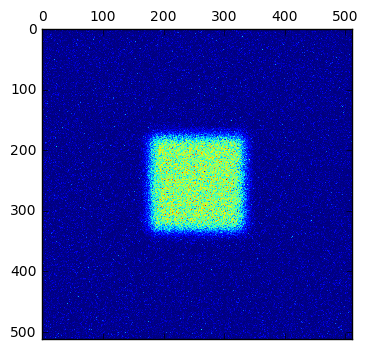

In [237]:
matshow(datadict["blurred_noisy"])

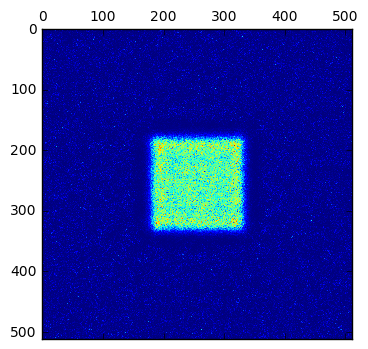

In [238]:
matshow(datadict["deconmat"])

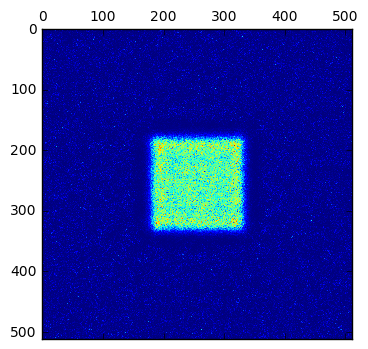

In [239]:
matshow(datadict["deconpy"])

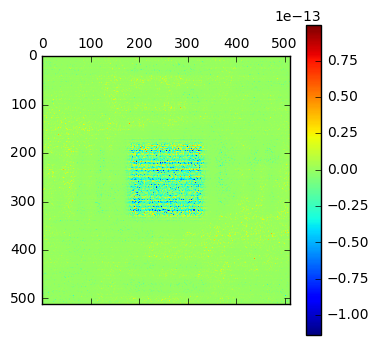

In [240]:
matshow(datadict["deconpy"] - datadict["deconmat"])
colorbar()

In [189]:
_zero2eps(array(0.0))

array(2.220446049250313e-16)

In [179]:
psf2 = fft_pad(psf, blurred_noisy.shape, mode="constant")

In [199]:
psf2.sum()

1.0

In [198]:
fftn(ifftshift(psf2))[0, 0]

(1+0j)

In [195]:
datadict["H"][0, 0]

(1+0j)

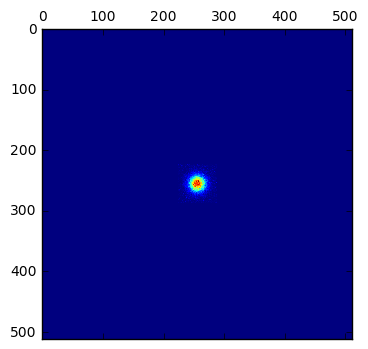

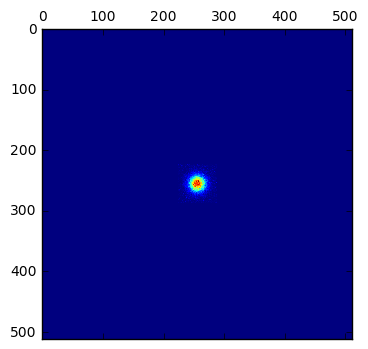

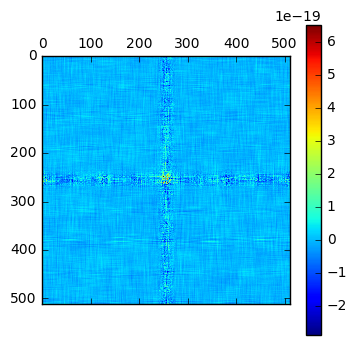

In [242]:
matshow(fftshift(ifftn(datadict["H"]).real))
matshow(psf2)
matshow(fftshift(ifftn(datadict["H"]).real) - psf2)
colorbar()